## Importing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output


from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import re

import spacy


# <span>View dataset</span>

In [3]:
train = pd.read_csv("./dataset/train_data.csv")
test = pd.read_csv("./dataset/test_data.csv")

In [4]:
train.count()

name                 4000
brand                4000
categories           4000
primaryCategories    4000
reviews.date         4000
reviews.text         4000
reviews.title        3990
sentiment            4000
dtype: int64

<p>We are able to observe that there are 4000 entries in the train dataset, for each column except <strong style="color: red;">reviews.title</strong>. This indicates that there are 10 missing or null entries, which should be treated in the later sections.</p>


In [5]:
test.count()

name                 1000
brand                1000
categories           1000
primaryCategories    1000
reviews.date         1000
reviews.text         1000
reviews.title         997
dtype: int64

We are able to observe that there are 1000 entries in the test dataset, for each column except <strong style="color: red;">reviews.title</strong>. This indicates that there are 3 missing or null entries, which should be treated in the later sections.

In [6]:
train.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,3990,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,4000,628,2600,99,4,100,3749


In [7]:
test.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,1000,1000,1000,1000,1000,1000,997
unique,23,1,23,4,366,979,796
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought the white version and have it in the ...,Great tablet
freq,169,1000,169,676,26,2,22


In [8]:
train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [9]:
test.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


# <span>1. Cleaning and preparing dataset</span>

### <strong style="color: blue;">1.1 Clean the data of errors and inconsistencies</strong>

#### <span >1.1a Dealing with duplicates</span>

In [10]:
# Viewing train duplicates
print("Number of duplicates in train dataset: " + str(train.duplicated().sum()))

Number of duplicates in train dataset: 58


In [11]:
# Viewing test duplicates
print("Number of duplicates in test dataset: " + str(test.duplicated().sum()))

Number of duplicates in test dataset: 3


In [12]:
# Dropping train & test duplicates
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [13]:
# View the train dataset after dropping (dropped 58 entries)
train.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,3942,3942,3942,3942,3942,3942,3932,3942
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,3942,628,2562,98,4,99,3694


In [14]:
# View the test dataset after dropping (dropped 3 entries)
test.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,997,997,997,997,997,997,994
unique,23,1,23,4,366,979,796
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,Got this tablet for my 7yr old daughter and it...,Great tablet
freq,169,997,169,673,26,2,22


### <strong style="color: blue;">1.2 Deal with missing values and outliers</strong>

#### <span >1.2a Dealing with missing or null values</span>

In [15]:
train.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [16]:
test.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        3
dtype: int64

In [17]:
train.dropna(axis=0, inplace = True)
test.dropna(axis=0, inplace= True)

In [18]:
train.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        0
sentiment            0
dtype: int64

In [19]:
test.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        0
dtype: int64

In [20]:
train.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,3932,3932,3932,3932,3932,3932,3932,3932
unique,23,1,23,4,630,3590,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,667,3932,628,2561,98,4,99,3684


In [21]:
test.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,994,994,994,994,994,994,994
unique,23,1,23,4,363,976,796
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,A great new Amazon device to add to my other A...,Great tablet
freq,169,994,169,673,26,2,22


#### <span >1.2b Dealing with outliers</span>

In [22]:
train.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

In [23]:
test.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
dtype: object

<p>The IQR method looks at the middle 50% of the data. Anything outside of 1.5 * IQR from the 1st and 3rd quartiles is considered an outlier. However since there all the types of the columns are of object type not numerical we don't deal with outliers.</p>

### <strong style="color: blue;">1.3 Transform the data into a format suitable for analysis and processing</strong>

#### <span >1.3a Imputations</span>

In [24]:
train.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

<p>No Imputations needed since there are no numerical entries </p>

#### <span >1.3b Adding/removing columns</span>

In [25]:
# Ensure 'reviews.date' is in datetime format
train['reviews.date'] = pd.to_datetime(train['reviews.date'])

# Create a new column 'review_year' by extracting the year from 'reviews.date'
train['review_year'] = train['reviews.date'].dt.year


In [26]:
train.tail()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_year
3937,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2017-12-08 00:00:00+00:00,"It‚Äôs fun for the family to play with, but it...",Fun toy,Positive,2017
3938,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,2017-03-31 00:00:00+00:00,"I love the Kindle, it is a great product. It r...",Great Product,Positive,2017
3939,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,Amazon,"Amazon Echo,Home Theater & Audio,MP3 MP4 Playe...",Electronics,2017-01-19 00:00:00+00:00,I was looking for a blutooth speaker to use wi...,"Great ""dumb"" speaker",Positive,2017
3940,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-05-27 00:00:00+00:00,This is the second Amazon Fire 7 tablet I have...,A great 7 inch tablet at a great price,Positive,2016
3941,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-30 00:00:00+00:00,"very satisfied with tablet, very fast and effi...",Gets the job done,Positive,2016


#### <span >1.3c Renaming columns</span>

In [27]:
train.columns

Index(['name', 'brand', 'categories', 'primaryCategories', 'reviews.date',
       'reviews.text', 'reviews.title', 'sentiment', 'review_year'],
      dtype='object')

In [28]:
train.rename(columns = {'reviews.text':'reviews_text', 'reviews.title':'reviews_title','reviews.date':'reviews_date', 'name':'product_name','brand':'product_brand','categories':'product_category','primaryCategories':'product_primary_category'}, inplace = True)

In [29]:
train.columns

Index(['product_name', 'product_brand', 'product_category',
       'product_primary_category', 'reviews_date', 'reviews_text',
       'reviews_title', 'sentiment', 'review_year'],
      dtype='object')

#### <span >1.3d Removing stopwords</span>

<span>tldr: Stop words are the words in a stop list which are filtered out before or after processing of natural language data because they are deemed insignificant</span>

In [30]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stanl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
nltk_stopwords = stopwords.words('english')
custom_stopwords = ['use', 'bought']
extended_stopwords = set(nltk_stopwords + custom_stopwords)
print(extended_stopwords)

{'what', "you'd", 'm', 'isn', 'because', 'between', 'is', 'had', "didn't", 'use', 'to', 'yours', "should've", "weren't", 'yourself', 'when', 'shan', 'over', 'very', 'mustn', 'you', 'he', 's', 'those', 'not', 'than', 'll', 'was', 'have', "mustn't", 'shouldn', 'after', 'hers', 'before', "you'll", 'they', 're', 'doesn', 'more', 'been', 'me', "you've", 'how', 'the', 'on', 'which', 'while', 'theirs', 'into', 'd', 'below', 'them', "won't", 'above', 'both', 'our', 'in', 'nor', 'ain', 'she', 'again', "aren't", 'having', 'until', 'from', 'as', 'mightn', 'now', 'their', 'has', 'should', 'being', 'won', 'her', 'be', 'so', "hadn't", 'itself', 'no', 'haven', 'i', 'any', 'too', 'down', 't', 'o', "shouldn't", 'then', 'weren', 'his', 'my', "that'll", "she's", 'were', 'these', 'themselves', "wasn't", "don't", 'aren', 've', 'where', 'off', 'at', 'that', 'hasn', 'will', 'ourselves', 'out', 'for', 'ours', 'it', 'only', "shan't", 'do', 'against', 'are', 'this', 'but', 'same', 'by', 'and', 'couldn', 'needn'

<p>We have to remove words that does not make sense to a computer to train the model better. We can also add custom words for the model to ignore whilst training.</p>

In [32]:
# Load spaCy English model (load it once outside the loop)
nlp = spacy.load("en_core_web_sm")

# Add extended stopwords to spaCy's stopwords list
for word in extended_stopwords:
    nlp.Defaults.stop_words.add(word)

In [33]:
print(train[['reviews_text']].head())

                                        reviews_text
0  Purchased on Black FridayPros - Great Price (e...
1  I purchased two Amazon in Echo Plus and two do...
2  Just an average Alexa option. Does show a few ...
3  very good product. Exactly what I wanted, and ...
4  This is the 3rd one I've purchased. I've bough...


In [34]:
# Function to remove stopwords and process text
def remove_stopwords(text_list):
    # If text_list is already a string of words, no need to join it
    if isinstance(text_list, list):
        text = ' '.join(text_list)  # Join words into a single string if it's a list
    else:
        text = text_list  # It's already a string

    # Process the text using spaCy
    doc = nlp(text)

    # Remove stopwords (whole words, not partial words or letters)
    filtered_words = [token.text for token in doc if not token.is_stop and not token.is_punct]
    
    # Join the filtered words to form a clean text
    clean_text = ' '.join(filtered_words)
    
    return clean_text

# Apply the function to the 'reviews_text' column and update it
train['reviews_text'] = train['reviews_text'].apply(remove_stopwords)

# Print some samples to verify
print(train[['reviews_text']].head())


                                        reviews_text
0  Purchased Black FridayPros Great Price sale)Ve...
1  purchased Amazon Echo Plus dots plus fire stic...
2         average Alexa option things screen limited
3             good product Exactly wanted good price
4  3rd purchased nieces case compares held protec...


# <span>2. Conducting exploratory data analysis (EDA)</span>

### <strong style="color: blue;">2.1 Explore the data to understand its distribution, the relationships between variables, and note any outlier</strong>

In [35]:
train.dtypes

product_name                             object
product_brand                            object
product_category                         object
product_primary_category                 object
reviews_date                datetime64[ns, UTC]
reviews_text                             object
reviews_title                            object
sentiment                                object
review_year                               int32
dtype: object

<p>We can observe that there are only object types and no numerical values thus outliers are out of scope.</p>

In [36]:
# Sentiment distribution
sentiment_distribution = train['sentiment'].value_counts()
sentiment_percentage = (sentiment_distribution / train['sentiment'].count()) * 100
print("Sentiment distribution (counts):\n", sentiment_distribution)
print("\n")
print("Sentiment distribution (percentage):\n", sentiment_percentage)


Sentiment distribution (counts):
 sentiment
Positive    3684
Neutral      158
Negative      90
Name: count, dtype: int64


Sentiment distribution (percentage):
 sentiment
Positive    93.692777
Neutral      4.018311
Negative     2.288911
Name: count, dtype: float64


<p>Based on the statistics above it shows that there is an overwhelming entries with positive sentiment. Thus this indicates a <strong>class imbalance</strong> problem.</p>

In [37]:
# train = train[train.sentiment != "Neutral"]

<p>We are using the Neutral sentiment as it gives actionable insights for companies later on, thus we are not dropping any sentiments.</p>

In [38]:
# Count of unique products
num_unique_products = train['product_name'].nunique()
print(f"Number of unique products: {num_unique_products}")

# Count of unique product brands
num_unique_brands = train['product_brand'].nunique()
print(f"Number of unique product brands: {num_unique_brands}")

# Count of unique product categories
num_unique_categories = train['product_category'].nunique()
print(f"Number of unique product categories: {num_unique_categories}")

# Count of unique primary product categories
num_unique_primary_categories = train['product_primary_category'].nunique()
print(f"Number of unique primary product categories: {num_unique_primary_categories}")


Number of unique products: 23
Number of unique product brands: 1
Number of unique product categories: 23
Number of unique primary product categories: 4


<p>Observing the above unique rows we are able to see that there are only 23 unique products and categories which could indicate a 1-1 relationship for product and category. Also there is only 1 unique brand which is Amazon so the model probably wouldn't do very well for non Amazon products.</p>

In [39]:
# Distribution of reviews by year
reviews_per_year = train['review_year'].value_counts().sort_index()
print("Reviews per year:\n", reviews_per_year)

Reviews per year:
 review_year
2014       9
2015      42
2016    1040
2017    2261
2018     580
Name: count, dtype: int64


<p>From the distribution of the year of the review, we are able to conclude that an overwhelming number of product review is made between the year 2016-2018. This could potentially introduce bias due to the trends, environment conditions & competitor product releases.</p>

In [40]:
# Most common products
top_products = train['product_name'].value_counts().head(10)
product_counts = train['product_name'].value_counts()
top_products_percentage = (top_products / product_counts.sum()) * 100
print("Top 10 most reviewed products:\n", top_products)
print("\n")
print("Percentage of each product:\n", top_products_percentage)
print("\n")

# Most common primary categories
primary_category_counts = train['product_primary_category'].value_counts()
top_primary_categories = primary_category_counts.head(10)
top_primary_categories_percentage = (top_primary_categories / primary_category_counts.sum()) * 100
print("Top primary product categories:\n", top_primary_categories)
print("\n")
print("Percentage of each primary category:\n", top_primary_categories_percentage)
print("\n")

Top 10 most reviewed products:
 product_name
Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen                                667
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta       628
Amazon - Echo Plus w/ Built-In Hub - Silver                                                    483
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                         446
Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue                        340
Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                          294
Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker                                          177
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                        175
Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers     122
Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Spec

<p>We are able to see that <strong>Amazon echo</strong> is the most reviewed product, with 667 reviews which represents almost 17% of the entire reviews. The primary category would be <strong>Electronics</strong> taking up 65% of the total reviews.</p>

In [41]:
# Add a column to store review length (number of words)
train['review_length'] = train['reviews_text'].apply(lambda x: len(x.split()))

# Average review length per sentiment
avg_review_length_by_sentiment = train.groupby('sentiment')['review_length'].mean()
print("Average review length by sentiment:\n", avg_review_length_by_sentiment)


Average review length by sentiment:
 sentiment
Negative    21.011111
Neutral     15.234177
Positive    12.962269
Name: review_length, dtype: float64


<p>Although roughly the same average length, we are able to see that usually positive reviews are <strong>shorter</strong> compared to negative reviews.</p>

In [42]:
# Extract hour of review from the review date
train['review_hour'] = train['reviews_date'].dt.hour

# Sentiment distribution by review hour
sentiment_by_hour = train.groupby('review_hour')['sentiment'].value_counts(normalize=True).unstack() * 100
print("Sentiment distribution by hour of review (percentage):\n", sentiment_by_hour)


Sentiment distribution by hour of review (percentage):
 sentiment     Negative     Neutral    Positive
review_hour                                   
0             2.271567    4.007147   93.721286
7                  NaN         NaN  100.000000
13                 NaN  100.000000         NaN
14                 NaN         NaN  100.000000
15                 NaN         NaN  100.000000
16                 NaN         NaN  100.000000
17                 NaN         NaN  100.000000
18                 NaN         NaN  100.000000
19                 NaN         NaN  100.000000
23           50.000000         NaN   50.000000


<p>We see that the above shows the timing which reviews are made. Negative reviews are only made during <strong>11pm to 12am</strong> however that is when most reviews are being given thus we cannot with confidence say that this is the trend.</p>

# 3. Visualising the data to help communicate the findings of your analysis.

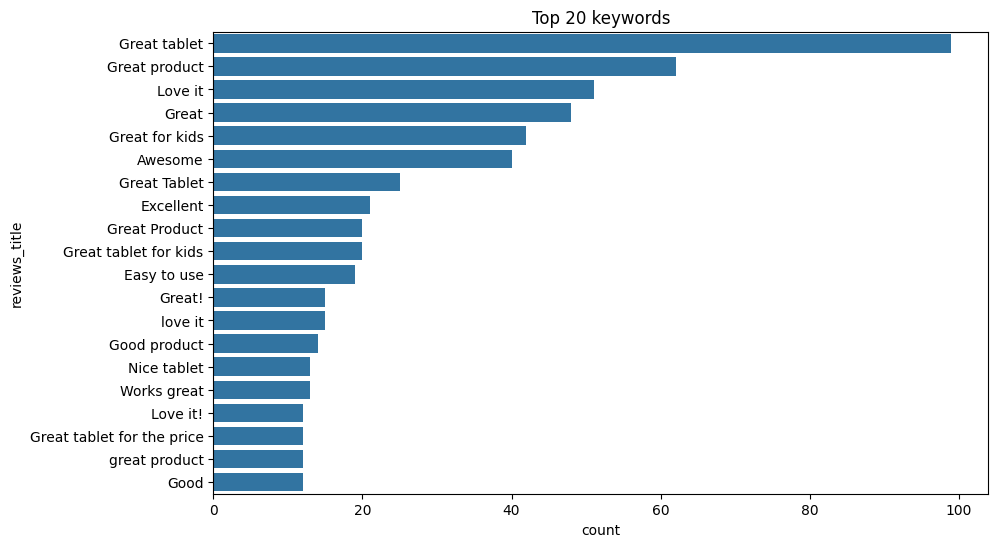

In [43]:
# Most common keywords
plt.figure(figsize=(10,6))
sns.countplot(y=train.reviews_title, order = train.reviews_title.value_counts().iloc[:20].index)
plt.title('Top 20 keywords')
plt.show()
# train.keyword.value_counts().head(10)

<p>Given that most product review is positive, we can see that the top 20 keywords are positive keywords in positive reviews most hinting towards positivity towards <strong>tablet</strong> products. </p>

Positive words


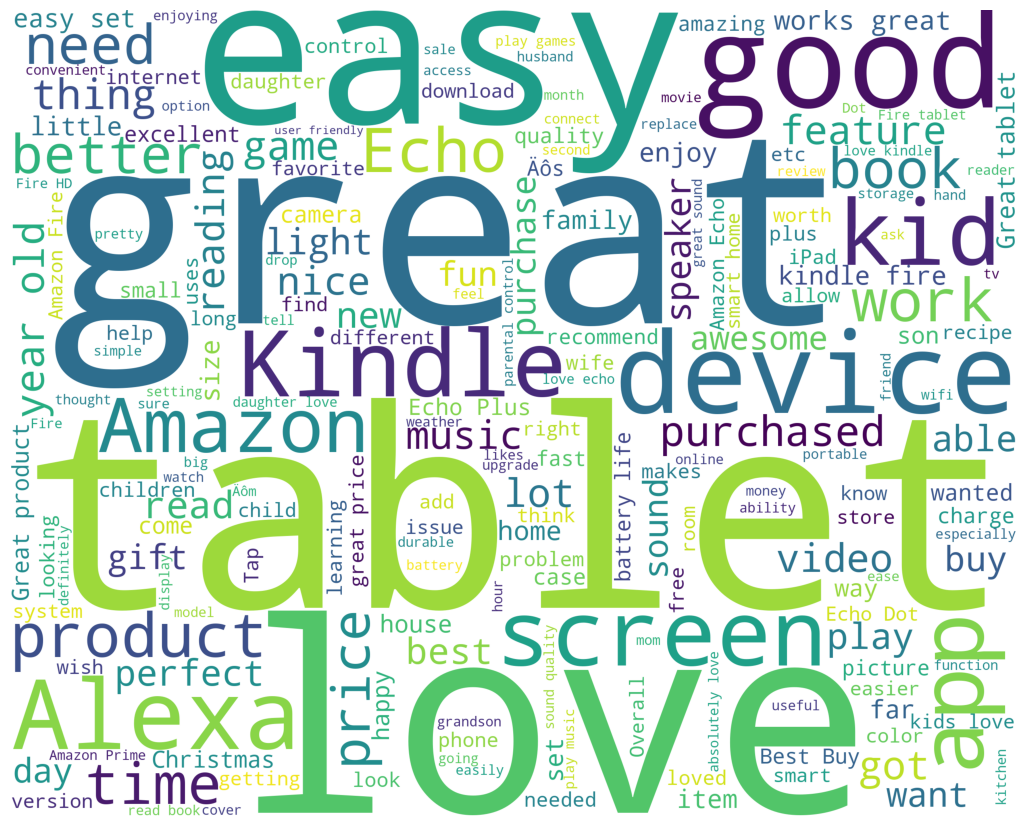

Negative words


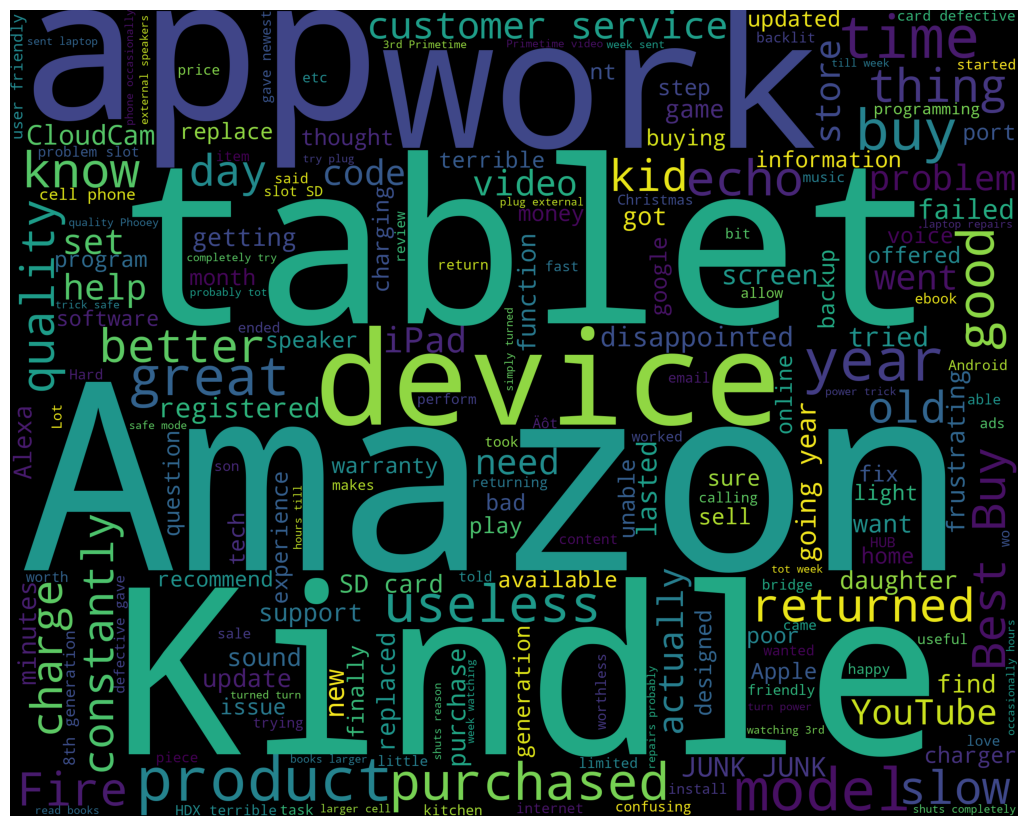

Neutral words


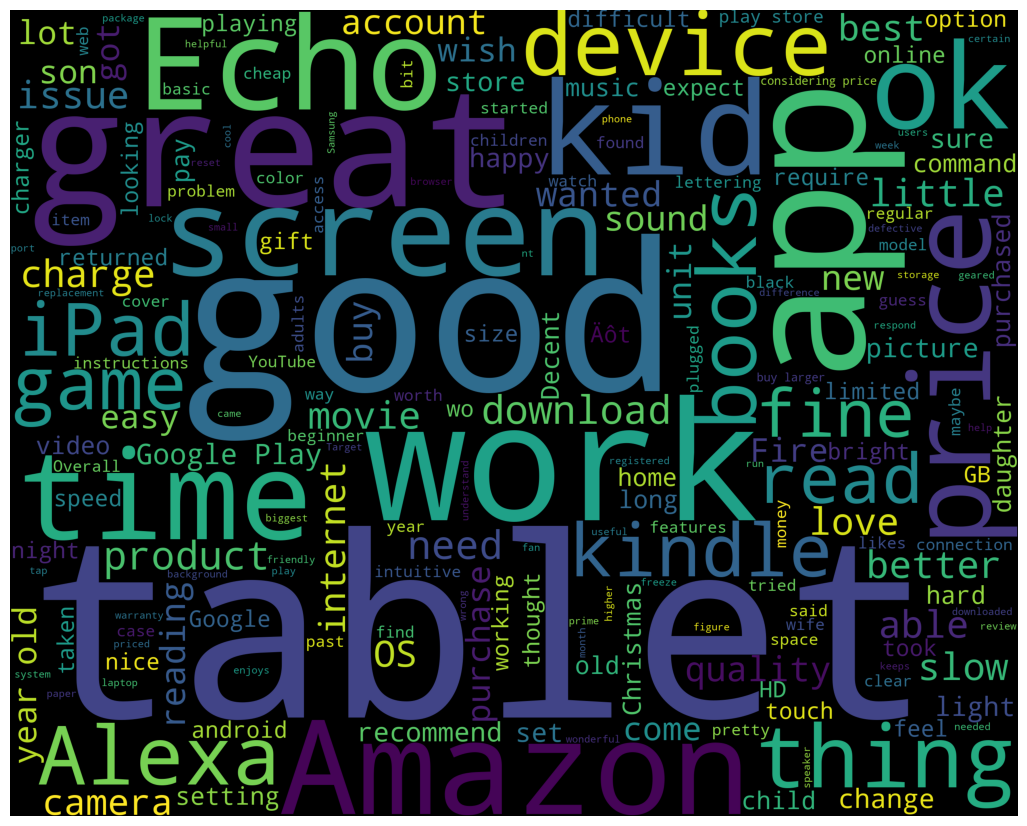

In [44]:
from wordcloud import WordCloud,STOPWORDS

train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['reviews_text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['reviews_text']
train_neu = train[ train['sentiment'] == 'Neutral']
train_neu = train_neu['reviews_text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)
print("Neutral words")
wordcloud_draw(train_neu)

<p>We can actually infer a lot of things from the word cloud above:</p>
<ul>
  <li>Identify products such as Kindle, which has more negative reviews compared to positive reviews. But given that there are way more positive reviews we can conclude that consumers don't like the Kindle product.</li>
  <li>We can also identify main obvious keywords such as <strong>returned</strong> from negative reviews and <strong>easy</strong> for positive.</li>
  <li>Also spot key issues with products, such as <strong>app</strong> is quite prominent in negative reviews perhaps due to problems with the integration of their Amazon products with their app.</li>
</ul>


In [45]:
# Convert sentiment values to lowercase
train['sentiment'] = train['sentiment'].str.lower()

# Map sentiment values to sentiment scores
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
train['sentiment_score'] = train['sentiment'].map(sentiment_map)

# Calculate the overall sentiment score (mean of sentiment scores)
overall_sentiment_score = train['sentiment_score'].mean()

# Output the overall sentiment score
print(f'Overall Sentiment Score: {overall_sentiment_score:.2f}')


Overall Sentiment Score: 0.91


<p>Sentiment score of 0.91 indicates that the overall product reviews are <strong>overwhelmingly positive</strong>.</p>

In [50]:
def calculate_product_sentiment_scores(df):
    # Ensure the sentiment is in lowercase
    df['sentiment'] = df['sentiment'].str.lower()

    # Map sentiment values to sentiment scores
    sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
    df['sentiment_score'] = df['sentiment'].map(sentiment_map)

    # Create an empty dictionary to store product-wise sentiment scores
    product_sentiment_scores = {}

    # Iterate through unique product names
    for product in df['product_name'].unique():
        # Filter the dataframe by the current product name
        product_data = df[df['product_name'] == product]

        # Calculate the mean sentiment score for the product
        mean_sentiment_score = product_data['sentiment_score'].mean()

        # Add the product and its sentiment score to the dictionary
        product_sentiment_scores[product] = mean_sentiment_score

    # Sort products by sentiment score (ascending order)
    sorted_product_scores = dict(sorted(product_sentiment_scores.items(), key=lambda x: x[1]))

    # Display the sorted results
    for product, score in sorted_product_scores.items():
        print(f'Product: {product}, Sentiment Score: {score:.2f}')

    return sorted_product_scores

# Example usage:
product_scores = calculate_product_sentiment_scores(train)


Product: Amazon Kindle E-Reader 6" Wifi (8th Generation, 2016), Sentiment Score: 0.83
Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue, Sentiment Score: 0.86
Product: Fire HD 8 Tablet with Alexa, 8" HD Display, 32 GB, Tangerine - with Special Offers, Sentiment Score: 0.86
Product: Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black, Sentiment Score: 0.86
Product: Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker, Sentiment Score: 0.86
Product: All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black, Sentiment Score: 0.87
Product: Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue, Sentiment Score: 0.88
Product: Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case, Sentiment Score: 0.89
Product: Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers, Sentiment Score: 0.90
Product: Fire Kids Edition Tablet, 7 Display

<p>From the word cloud we theorized that <strong>Kindle</strong> is not loved by consumers and we confirm this using the the sentiment score. Thus we can have a better insight as to how liked a product is by its users.</p>

In [51]:
import plotly.graph_objects as go
import numpy as np

# Assume the 'train' DataFrame has a 'sentiment_score' column
# Calculate the overall sentiment score (mean of sentiment scores)
overall_sentiment_score = train['sentiment_score'].mean()

# Ensure the score is within the valid range (0 to 100)
current_value = max(0, min(100, overall_sentiment_score * 100))  # Scale sentiment to 0-100 range if needed

plot_bgcolor = "#def"
quadrant_colors = [plot_bgcolor, "#2bad4e", "#85e043", "#eff229", "#f2a529", "#f25829"]
quadrant_text = ["", "<b>Very Positive</b>", "<b>Positive</b>", "<b>Neutral</b>", "<b>Negative</b>", "<b>Very Negative</b>"]
n_quadrants = len(quadrant_colors) - 1

min_value = 0
max_value = 100
hand_length = np.sqrt(2) / 4
hand_angle = np.pi * (1 - (max(min_value, min(max_value, current_value)) - min_value) / (max_value - min_value))

# Define custom line widths for the outline (with an outline on "Very Positive")
line_widths = [0, 5, 0, 0, 0, 0]  # Only set width for the second section ("Very Positive")
line_colors = ["rgba(0, 0, 0, 0)", "#000", "rgba(0, 0, 0, 0)", "rgba(0, 0, 0, 0)", "rgba(0, 0, 0, 0)", "rgba(0, 0, 0, 0)"]  # Use transparent color for no outline

fig = go.Figure(
    data=[
        go.Pie(
            values=[0.5] + (np.ones(n_quadrants) / 2 / n_quadrants).tolist(),
            rotation=90,
            hole=0.4,  # Decrease the hole size for better visibility of inner lines
            marker=dict(
                colors=quadrant_colors,
                line=dict(width=line_widths, color=line_colors)  # Use transparent color where no outline is needed
            ),
            text=quadrant_text,
            textinfo="text",
            hoverinfo="skip",
        ),
    ],
    layout=go.Layout(
        showlegend=False,
        margin=dict(b=0, t=10, l=10, r=10),
        width=450,
        height=450,
        paper_bgcolor=plot_bgcolor,
        annotations=[
            go.layout.Annotation(
                text=f"<b>Sentiment Score:</b><br>{current_value:.2f}",
                x=0.5, xanchor="center", xref="paper",
                y=0.25, yanchor="bottom", yref="paper",
                showarrow=False,
            )
        ],
        shapes=[
            go.layout.Shape(
                type="circle",
                x0=0.48, x1=0.52,
                y0=0.48, y1=0.52,
                fillcolor="#333",
                line_color="#333",
            ),
            go.layout.Shape(
                type="line",
                x0=0.5, x1=0.5 + hand_length * np.cos(hand_angle),
                y0=0.5, y1=0.5 + hand_length * np.sin(hand_angle),
                line=dict(color="#333", width=4)
            )
        ]
    )
)
fig.show()


<p>Just a visualization to better visualize the overall sentiment of all the reviews.</p>

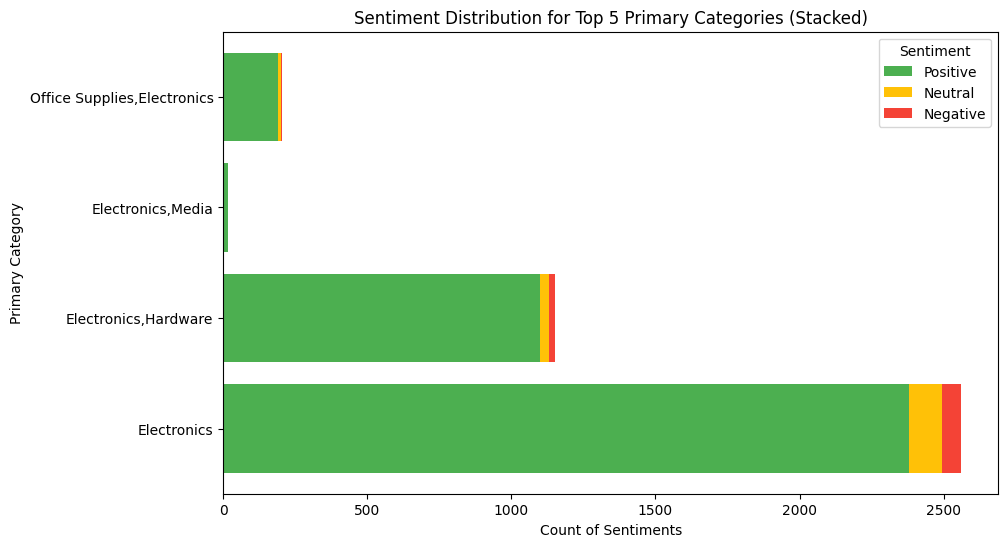

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train' contains the cleaned data with 'product_primary_category' and 'sentiment' columns
# Convert sentiment to lowercase if not already done
train['sentiment'] = train['sentiment'].str.lower()

# Group by product primary category and sentiment, and count occurrences
category_sentiment_counts = train.groupby(['product_primary_category', 'sentiment']).size().reset_index(name='count')

# Calculate the total count of sentiments per primary category
category_totals = category_sentiment_counts.groupby('product_primary_category')['count'].sum().reset_index()

# Get the top 5 primary categories by total sentiment count
top_5_categories = category_totals.nlargest(5, 'count')['product_primary_category']

# Filter the original sentiment data to only include the top 5 primary categories
top_5_data = category_sentiment_counts[category_sentiment_counts['product_primary_category'].isin(top_5_categories)]

# Pivot the data so that each sentiment becomes a separate column
category_sentiment_pivot = top_5_data.pivot(index='product_primary_category', columns='sentiment', values='count').fillna(0)

# Create a stacked horizontal bar chart
plt.figure(figsize=(10, 6))

# Define the sentiments and colors for the bars
sentiments = ['positive', 'neutral', 'negative']
colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Yellow, Red

# Initialize the bottom to start from zero
bottom = np.zeros(len(category_sentiment_pivot))

# Plot each sentiment as a stacked bar
for i, sentiment in enumerate(sentiments):
    plt.barh(category_sentiment_pivot.index, category_sentiment_pivot[sentiment], left=bottom, label=sentiment.capitalize(), color=colors[i])
    # Update the bottom to stack the next sentiment on top
    bottom += category_sentiment_pivot[sentiment]

# Add labels and title
plt.xlabel('Count of Sentiments')
plt.ylabel('Primary Category')
plt.title('Sentiment Distribution for Top 5 Primary Categories (Stacked)')
plt.legend(title='Sentiment')
plt.show()


<p>With a stacked bar chart we are able to see the distribution of the sentiment for reviews for each primary category. We can observe that <strong>Electronics</strong> category has the most negative reviews but also has the most overall reviews. Thus we cannot say with confidence that the electronic category has the most hate but can confidently say that electronics is sold the most.</p>

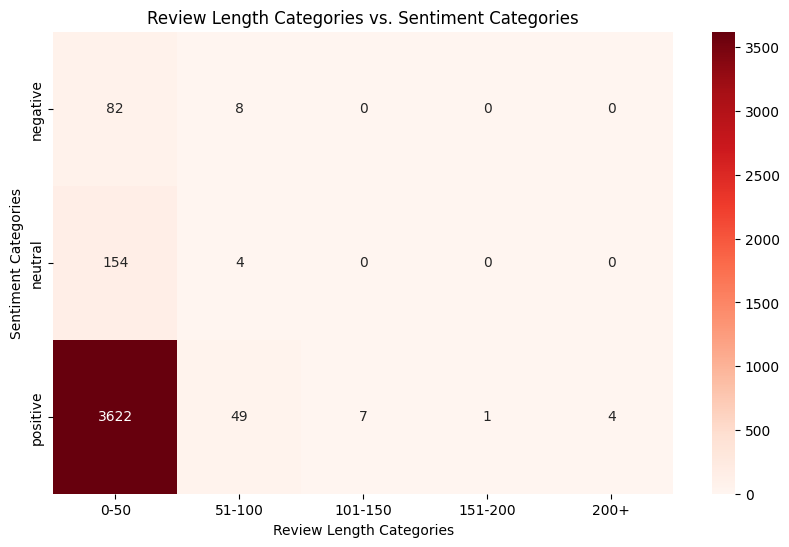

In [52]:
# Define bins for categorizing the review lengths
bins = [0, 50, 100, 150, 200, np.inf]
labels = ['0-50', '51-100', '101-150', '151-200', '200+']

# Categorize the review lengths based on the defined bins
train['length_category'] = pd.cut(train['review_length'], bins=bins, labels=labels)

# Create a pivot table to show the frequency of each sentiment category in each review length range
matrix = pd.crosstab(train['sentiment'], train['length_category'])

# Plot the matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap='Reds')
plt.title('Review Length Categories vs. Sentiment Categories')
plt.xlabel('Review Length Categories')
plt.ylabel('Sentiment Categories')
plt.show()



<p>The heatmap above shows that most reviews are relatively short between <strong>0-50 words</strong> and is mostly positive. However that doesn't mean that positive reviews are generally short, we can only conclude that users usually leave short reviews.</p>